In [20]:
import os
import numpy as np
import time as time

# Import torch and select GPU
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

# Plot functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Radio and convex reg functions
import quantifai as qai
from quantifai.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg


True
1
0
NVIDIA A100-PCIE-40GB


In [21]:

import ptwt
import math
from quantifai.utils import max_eigenval
from quantifai.empty import Identity

## Start development


In [46]:
class Wavelets_torch(torch.nn.Module):
    """
    Constructs a linear operator for abstract Daubechies Wavelets
    """

    def __init__(self, wav, levels, mode="periodic", shape=None):
        """Initialises Daubechies Wavelet linear operator class

        Args:

            wav (string): Wavelet type (see https://tinyurl.com/5n7wzpmb)
            levels (int): Wavelet levels (scales) to consider
            mode (str): Wavelet signal extension mode
            shape (tuple): image shape

        Raises:

            ValueError: Raised when levels are not positive definite
            ValueError: Raised if the wavelet type is not a string
            ValueError: Raised if wavelet type is `self` and a shape is not provided

        """
        super().__init__()
        if np.any(levels <= 0):
            raise ValueError("'levels' must be positive")
        if not isinstance(wav, str):
            raise ValueError("'wav' must be a string")
        self.wav = wav
        self.levels = np.int64(levels)
        self.mode = mode

        if wav == "self":
            self.shape = shape
            if shape is None:
                raise ValueError("`self` wavelet type requires the shape of the images as input.")

            self.adj_op(self.dir_op(torch.ones(self.shape)))
        else:
            self.adj_op(self.dir_op(torch.ones((1, 64, 64))))

    def dir_op(self, x):
        """Evaluates the forward abstract wavelet transform of x

        Args:

            x (torch.Tensor): Array to wavelet transform. Can be [batch, H, W] or [H, W],
                but it will raise an error if used with [batch, channels, H, W].

        Returns:

            coeffs (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Wavelet decomposition coefficients

        Raises:

            ValueError: Raised when the shape of x is not even in every dimension
        """
        if self.wav == "self":
            return torch.ravel(x)
        else:
            if x.dim() >= 4:
                return ptwt.wavedec2(
                    x.squeeze(1), wavelet=self.wav, level=self.levels, mode=self.mode
                )
            else:
                return ptwt.wavedec2(x, wavelet=self.wav, level=self.levels, mode=self.mode)

    def adj_op(self, coeffs):
        """Evaluates the forward adjoint abstract wavelet transform of x

        Args:

            coeffs (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Wavelet decomposition coefficients

        Returns:

            img (torch.Tensor): reconstruted image.
        """
        if self.wav == "self":
            return torch.reshape(coeffs, self.shape)
        else:
            return ptwt.waverec2(coeffs, wavelet=self.wav).squeeze(1)



In [47]:
class DictionaryWv_torch(torch.nn.Module):
    """
    Constructs class to permit sparsity averaging across a collection of wavelet dictionaries
    """

    def __init__(self, wavs, levels, mode="periodic", shape=None):
        """Initialises a linear operator for a collection of abstract wavelet dictionaries

        Args:

            wavs (list[string]): List of wavelet types (see https://tinyurl.com/5n7wzpmb)
            levels (list[int]): Wavelet levels (scales) to consider
            mode (str): Wavelet signal extension mode shared by all dictionaries
            shape (tuple): image shape

        Raises:

            ValueError: Raised when levels are not positive definite

        """
        super().__init__()
        self.wavelet_list = []
        self.mode = mode
        self.wavs = wavs
        self.levels = levels
        self.shape = shape
        if np.isscalar(levels):
            self.levels = np.ones(len(self.wavs)) * levels
        for i in range(len(self.wavs)):
            self.wavelet_list.append(
                Wavelets_torch(self.wavs[i], self.levels[i], self.mode, self.shape)
            )

    def dir_op(self, x):
        """Evaluates a list of forward abstract wavelet transforms of x

        Args:

            x (torch.Tensor): Tensor to wavelet transform

        """
        buff = []
        buff.append(self.wavelet_list[0].dir_op(x))
        for wav_i in range(1, len(self.wavelet_list)):
            buff.append(self.wavelet_list[wav_i].dir_op(x))
        return buff

    def adj_op(self, coeffs):
        """Evaluates a list of forward adjoint abstract wavelet transforms of x

        Args:

            coeffs (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Coefficients to adjoint wavelet transform

        """
        out = self.wavelet_list[0].adj_op(coeffs[0])
        for wav_i in range(1, len(self.wavelet_list)):
            out = out + self.wavelet_list[wav_i].adj_op(coeffs[wav_i])
        return out / len(self.wavelet_list)
    



In [23]:
# Parameters

# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 100, "record_iters": False}

# Save param
repo_dir = "./../.."

# Test image name from ['M31', 'W28', 'CYN', '3c288']
img_name = "M31"
# Input noise level
input_snr = 30.0

# Define my torch types (CRR requires torch.float32)
myType = torch.float64
myComplexType = torch.complex128

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = "./../../trained_models/"
# CRR parameters
lmbd = 5e4  # lambda parameter
mu = 20

In [24]:
# Load image and mask
img, mat_mask = qai.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img

torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape(
    (1, 1) + img.shape
)

phi = qai.operators.MaskedFourier_torch(
    shape=img.shape, ratio=0.5, mask=mat_mask, norm="ortho", device=device
)

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Define noise level
eff_sigma = qai.helpers.compute_complex_sigma_noise(y, input_snr)
sigma = eff_sigma * np.sqrt(2)

# Generate noise
rng = np.random.default_rng(seed=0)
n_re = rng.normal(0, eff_sigma, y[y != 0].shape)
n_im = rng.normal(0, eff_sigma, y[y != 0].shape)
# Add noise
y[y != 0] += n_re + 1.0j * n_im

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape(
    (1,) + img.shape
)
# Generate first guess
x_init = torch.abs(phi.adj_op(torch_y))

INSTRUME                                                                         [astropy.io.fits.card]


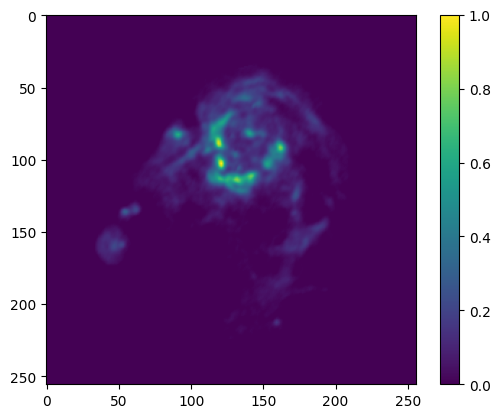

In [25]:

plt.figure()
plt.imshow(to_numpy(torch_img))
plt.colorbar()
plt.show()


In [42]:

wavelet = Wavelets_torch(
    wav="self",
    levels=4,
    mode="periodic",
    shape=torch_img.shape
)


In [43]:
coeffs = wavelet.dir_op(torch_img.clone())

In [44]:
recon_img = wavelet.adj_op(coeffs)

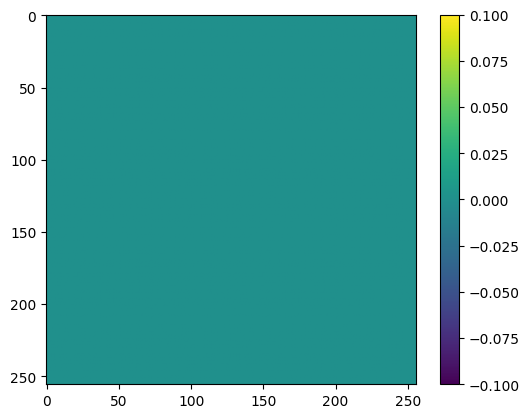

In [45]:

plt.figure()
plt.imshow(to_numpy(torch_img - recon_img))
plt.colorbar()
plt.show()

In [51]:

wavelet_dict = DictionaryWv_torch(
    wavs=["db2", "db4", "self"],
    levels=4,
    mode="periodic",
    shape=torch_img.shape
)


In [52]:
coeff_list = wavelet_dict.dir_op(torch_img.clone())

In [53]:
recon_img_list = wavelet_dict.adj_op(coeff_list)

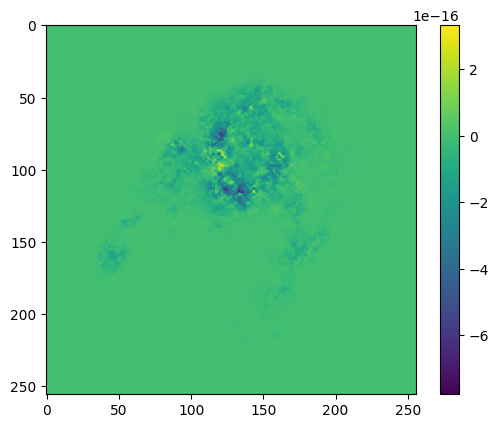

In [54]:
plt.figure()
plt.imshow(to_numpy(torch_img - recon_img_list))
plt.colorbar()
plt.show()
